### 使用 VQLS 算法求解，给定接近最优参数的位置

In [1]:
# 导入必要的库
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as qml_np

import numpy as np
import time
import VQLS_until

In [2]:
# 参数设置
steps = 30  # 迭代次数
eta = 0.01  # 学习率
seed = 1024 # 种子数
tol = 1e-4 # 终止条件
deep_layer = 3 # 电路层数
qubits = 3

# 优化器
# opt = qml.GradientDescentOptimizer(stepsize=0.1)
opt = qml.AdamOptimizer(stepsize=0.1)


qml_np.random.seed(1024)


# # 最优参数
w_old = qml_np.array([3.14161205e+00,  5.80377608e+00,  3.93857269e+00,
         4.71236102e+00,  4.42799279e+00,  5.32962513e+00,
         2.88556879e-05, -6.91562619e-02,  4.79375314e-01])

# 进行随机的微小的扰动
error = qml_np.random.uniform(low=-0.01, high=0.01, size=(deep_layer * qubits,))

w = qml_np.array(w_old + error)
print(error)
print(w)


[ 0.00295382  0.00993827  0.00037607  0.00316225  0.00198127  0.00506135
 -0.00727506 -0.00991766 -0.00700982]
[ 3.14456587  5.81371435  3.93894876  4.71552327  4.42997406  5.33468648
 -0.0072462  -0.07907392  0.47236549]


In [3]:
opt = qml.GradientDescentOptimizer(eta)

cost_history = []
w_history = []
for it in range(steps):
    print("step  = ", it)
    
    start = time.time()
    
    w, cost = opt.step_and_cost(VQLS_until.cost_loc, w)
    w_history.append(w)
    cost_history.append(cost)
    
    end = time.time()
    
    print("Cost_L = {:9.7f}".format(cost))
    print("time = ", end - start)

    if cost < tol:
        break    

step  =  0
Cost_L = 0.0059363
time =  1106.2919578552246
step  =  1
Cost_L = 0.0008115
time =  1158.0064013004303
step  =  2
Cost_L = 0.0001432
time =  1726.8773696422577
step  =  3
Cost_L = 0.0000569
time =  1838.2808065414429


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


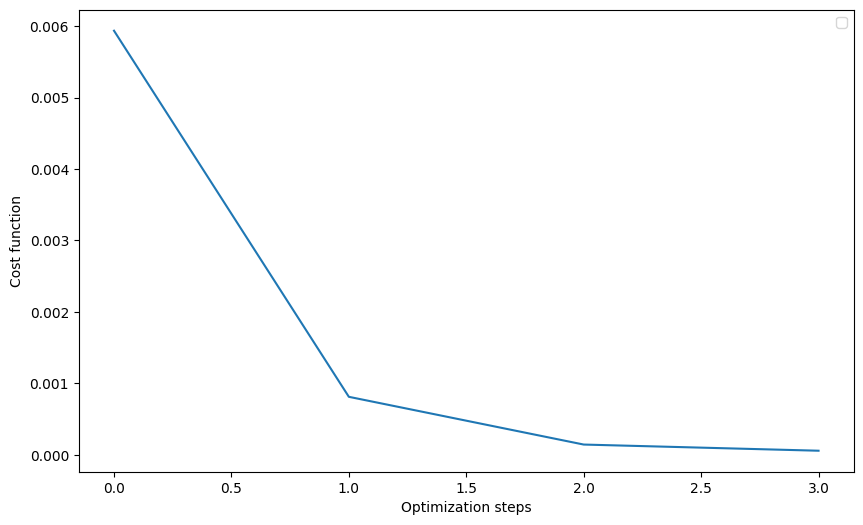

In [4]:
# 创建图形和轴
plt.figure(figsize=(10, 6))

# 绘制折线图
plt.plot(range(len(cost_history)), cost_history)

# 添加标题和标签
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.grid
plt.legend()

# 显示图形
plt.show()

In [5]:
x_normalized = VQLS_until.x_normalized
H_matrix_2 = VQLS_until.H_matrix_2
b_norm = VQLS_until.b_norm

# 表示经典情况下，量子态在每个基向量上的概率
c_probs = (x_normalized) ** 2

# 返回测量值(shots = 2048)，或者是返回量子态形式
shots = 2048
x_sample = VQLS_until.sample_and_state(w, method='sample')
x_state = VQLS_until.sample_and_state(w, method='state')

# 将各种测量结果汇总，获得相关概率
samples = []
for sam in x_sample:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / shots


value = np.sqrt(x_state.real.reshape(1,-1).conj() @ H_matrix_2.conj().T @ H_matrix_2 @ x_state.real.reshape(-1,1))
x_state_value = b_norm * x_state/value

print("c_probs = ", c_probs)
print("q_probs = ", q_probs)
print("x_normalized = ", x_normalized)
print("x_state = ", x_state)
print("x_state_value= ", x_state_value)

c_probs =  [0.         0.         0.         0.80898876 0.14044944 0.0505618
 0.         0.        ]
q_probs =  [0.         0.         0.         0.81152344 0.13427734 0.05419922]
x_normalized =  [0.         0.         0.         0.89943803 0.37476584 0.22485951
 0.         0.        ]
x_state =  [-3.96756011e-05+0.j -1.57331632e-04+0.j -7.34464496e-05+0.j
  8.99747377e-01+0.j  3.73994144e-01+0.j  2.24897056e-01+0.j
  2.07478935e-03+0.j  1.24512980e-04+0.j]
x_state_value=  [[-5.29424198e-02+0.j -2.09940545e-01+0.j -9.80056423e-02+0.j
   1.20060697e+03+0.j  4.99051166e+02+0.j  3.00098651e+02+0.j
   2.76856218e+00+0.j  1.66147916e-01+0.j]]


/root/miniconda3/envs/pennylane_gpu/lib/python3.9/site-packages/pennylane/_qubit_device.py:666: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  warnings.warn(


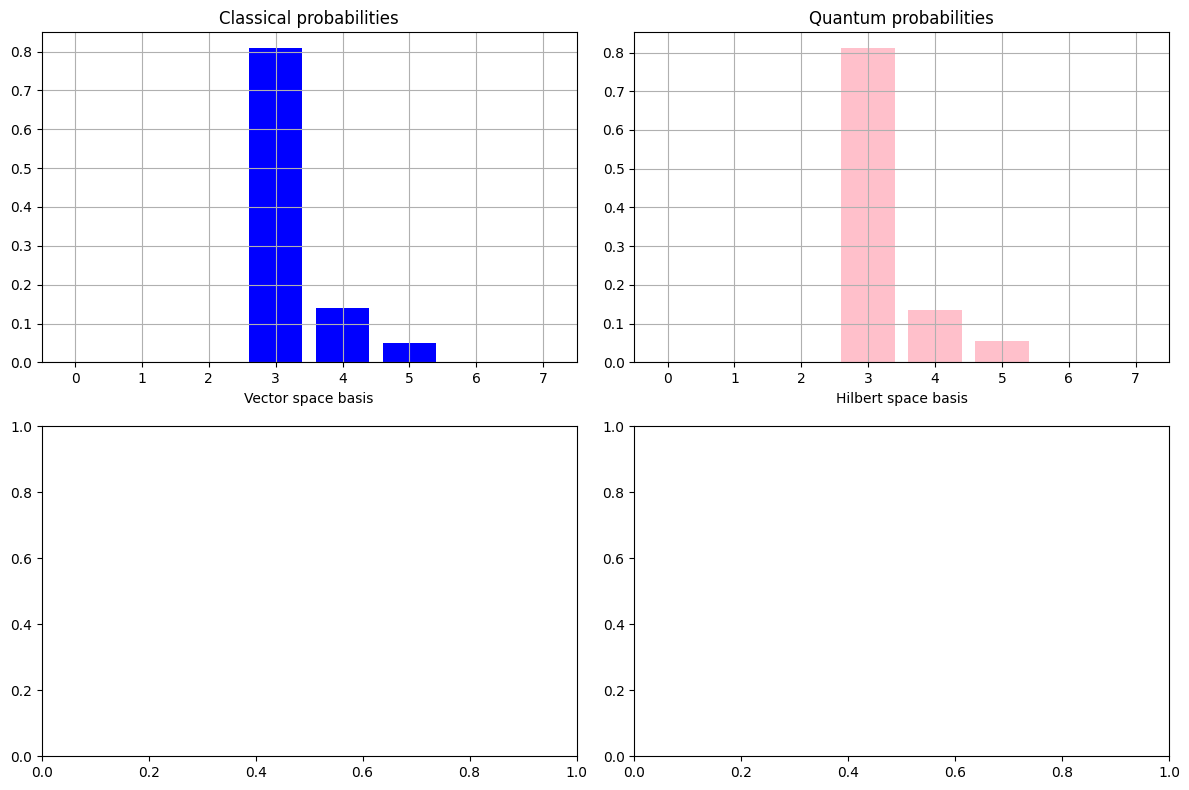

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.bar(np.arange(0, 2 ** qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")
ax1.grid(True)  

ax2.bar(np.arange(0, len(q_probs)), q_probs, color="pink")
ax2.set_xlim(-0.5, 2 ** qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")
ax2.grid(True)

# 调整布局以防止子图重叠
plt.tight_layout()
plt.show()

In [10]:
print("cost_history = ", cost_history)
print("w_history = ", w_history)

cost_history =  [0.0059363237129275714, 0.0008115041947696633, 0.0001432343293170657, 5.689293014599084e-05]
w_history =  [tensor([ 3.14111959e+00,  5.81599032e+00,  3.93878788e+00,
         4.71515580e+00,  4.42378508e+00,  5.33120643e+00,
         9.08090038e-04, -7.61096844e-02,  4.74641459e-01], requires_grad=True), tensor([ 3.14219753e+00,  5.81528292e+00,  3.94036633e+00,
         4.71526820e+00,  4.42518005e+00,  5.33195468e+00,
        -1.66050432e-03, -7.55348397e-02,  4.73934056e-01], requires_grad=True), tensor([ 3.14201514e+00,  5.81540524e+00,  3.94090093e+00,
         4.71524406e+00,  4.42476187e+00,  5.33185617e+00,
        -1.23099256e-03, -7.48104432e-02,  4.74056379e-01], requires_grad=True), tensor([ 3.14205787e+00,  5.81537851e+00,  3.94134631e+00,
         4.71524587e+00,  4.42473918e+00,  5.33191857e+00,
        -1.33491316e-03, -7.43916138e-02,  4.74029654e-01], requires_grad=True)]


In [11]:
w_history[-1]

tensor([ 3.14205787e+00,  5.81537851e+00,  3.94134631e+00,
         4.71524587e+00,  4.42473918e+00,  5.33191857e+00,
        -1.33491316e-03, -7.43916138e-02,  4.74029654e-01], requires_grad=True)